In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', 50)


# EDA, Data cleaning, Feature Engineering

## ug_fact_reading_result

In [2]:
df =  pd.read_excel('../../raw_data/Uganda - 2024 10 02(v1).xlsx', sheet_name='ug_fact_reading_result')
df.head()

,ChildrenId,ResultBaseline,ResultRound1,ResultRound2,ResultRound3,ResultEndline,Baseline to Round 1,Round 1 to Round 2,Round 2 to Round 3,Round 3 to Endline,Baseline to Endline,Completing Result Baseline to Endline-Story/Comprehension Level,AcademicYearId,Year,Gender,Baseline_Endline,ComprehensionAchieved,StoryAchieved,TrackIncreaseOneLevel,AttendanceIncreaseOneLevel,TotalhoursIncreaseOnelevel,IsCUCSatisfied?,AtLeastAchievedSentence,Identity_Number,SchoolId
0,36161,Word,NaN,Story with comprehension,NaN,Story with comprehension,NaN,NaN,NaN,NaN,Increase,True,26,2022,Male,Increase 3 Levels,True,False,False,NaN,NaN,9.0,True,NaN,185
1,31440,Letter,NaN,Story with comprehension,NaN,Story with comprehension,NaN,NaN,NaN,NaN,Increase,True,26,2022,Female,Increase 4 Levels,True,False,False,NaN,NaN,8.0,True,NaN,185
2,31439,NaN,Word,Story with comprehension,NaN,Story with comprehension,NaN,Increase,NaN,NaN,NaN,False,26,2022,Female,NaN,True,False,False,NaN,NaN,8.0,True,NaN,185
3,36133,NaN,NaN,NaN,NaN,Story with comprehension,NaN,NaN,NaN,NaN,NaN,False,26,2022,Male,NaN,True,False,False,NaN,NaN,8.0,True,NaN,185
4,36143,Word,NaN,NaN,NaN,Story with comprehension,NaN,NaN,NaN,NaN,Increase,True,26,2022,Male,Increase 3 Levels,True,False,False,NaN,NaN,8.0,True,NaN,185


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32695 entries, 0 to 32694
Data columns (total 25 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   ChildrenId                                                       32695 non-null  int64  
 1   ResultBaseline                                                   25579 non-null  object 
 2   ResultRound1                                                     22282 non-null  object 
 3   ResultRound2                                                     16883 non-null  object 
 4   ResultRound3                                                     3206 non-null   object 
 5   ResultEndline                                                    15375 non-null  object 
 6   Baseline to Round 1                                              17749 non-null  object 
 7   Round 1 to Round 2                      

In [4]:
def unique_vals(df, only_categorical_cols = False, only_object = False):
    res = pd.DataFrame()
    cols = []
    nunique = []
    unique = []
    datatype = []
    num_of_nan = []
    for column in df:
        cols.append(column)
        nunique.append(df[column].nunique() )
        unique.append( df[column].unique() )
        datatype.append(df[column].dtype)
        num_of_nan.append(df[column].isnull().sum())
        
    
    res['col_name'] = cols
    res['number_of_unique_values'] = nunique
    res['unique_values'] = unique
    res['dtype'] = datatype
    res['number_of_nan'] = num_of_nan

    if only_categorical_cols and only_object:
        res = res[res['dtype']=='object']
        return res[res['number_of_unique_values']<500].sort_values('number_of_unique_values')

    if only_categorical_cols:
        return res[res['number_of_unique_values']<500].sort_values('number_of_unique_values')

    if only_object:
        return res[res['dtype']=='object'].sort_values('number_of_unique_values')


    return res.sort_values('number_of_unique_values')

# after correlation analysis and based on data cictionary following columns were more useful than others
cols = ['ChildrenId', 'ResultBaseline', 'ResultRound1', 'ResultRound2',
       'ResultRound3', 'ResultEndline', 'Baseline to Round 1',
       'Round 1 to Round 2', 'Round 2 to Round 3', 'Round 3 to Endline',
       'Baseline to Endline', 
       'Completing Result Baseline to Endline-Story/Comprehension Level', 
        'AtLeastAchievedSentence', 'ComprehensionAchieved', 'StoryAchieved', 'Baseline_Endline', 'Gender', 'AcademicYearId']

# drop columns where 70% of data is nan
df = df[cols].dropna(thresh=len(df) * 0.3, axis=1)

# since Baseline_Endline column is our target delete NAN values:
df = df.dropna(subset=['Baseline to Endline'])
unique_vals(df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
8,Completing Result Baseline to Endline-Story/Co...,2,"[True, False]",bool,0
9,AtLeastAchievedSentence,2,"[True, False]",bool,0
10,ComprehensionAchieved,2,"[True, False]",bool,0
11,StoryAchieved,2,"[False, True]",bool,0
5,Baseline to Round 1,3,"[nan, Increase, Stayed The Same, Decrease]",object,2157
6,Round 1 to Round 2,3,"[nan, Increase, Stayed The Same, Decrease]",object,3738
7,Baseline to Endline,3,"[Increase, Stayed The Same, Decrease]",object,0
13,Gender,3,"[Male, Female, Unknown]",object,0
1,ResultBaseline,6,"[Word, Letter, Sentence, Beginner, Story, Stor...",object,0
2,ResultRound1,6,"[nan, Story with comprehension, Story, Word, L...",object,2157


In [5]:
# Other columns are string object type, filling nan values by 0
df = df.fillna('null')

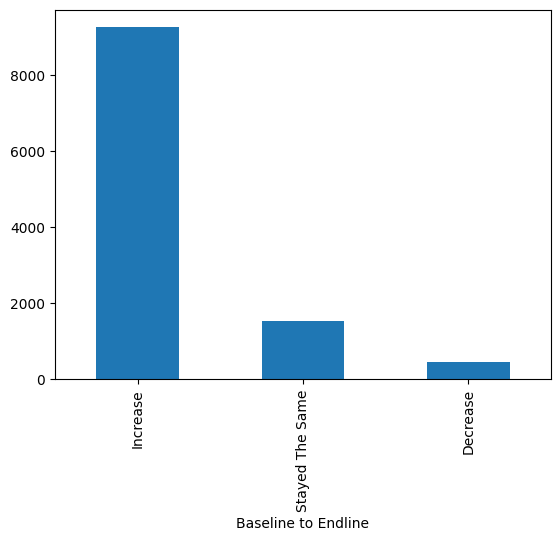

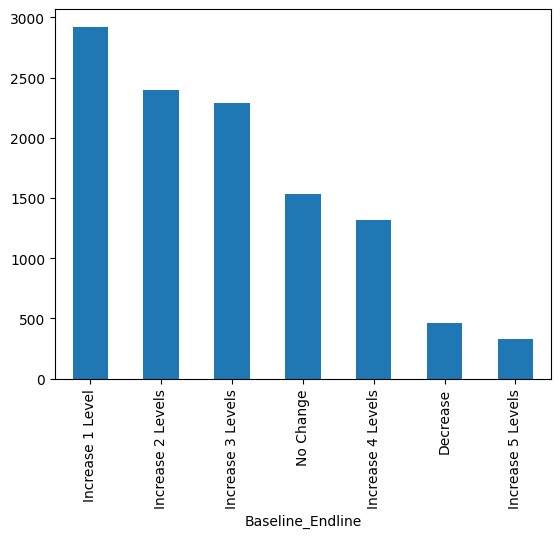

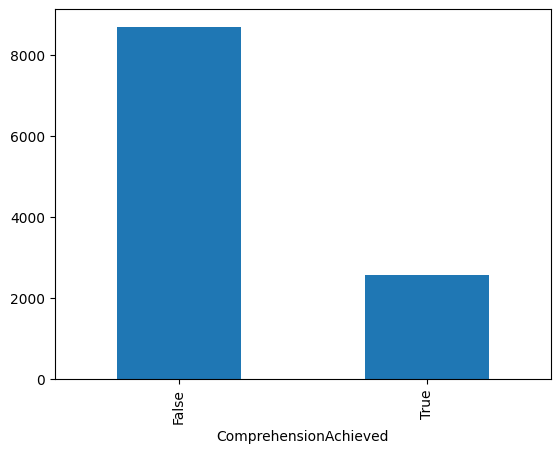

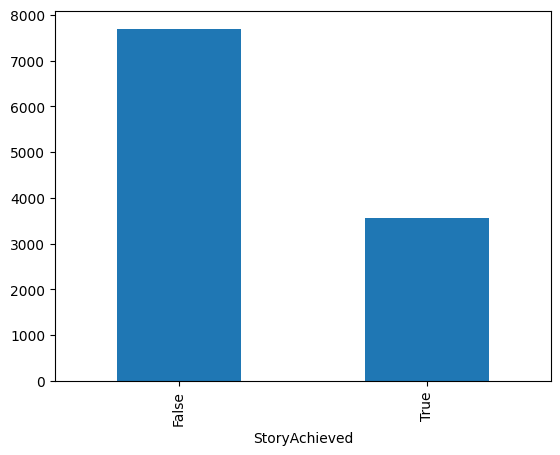

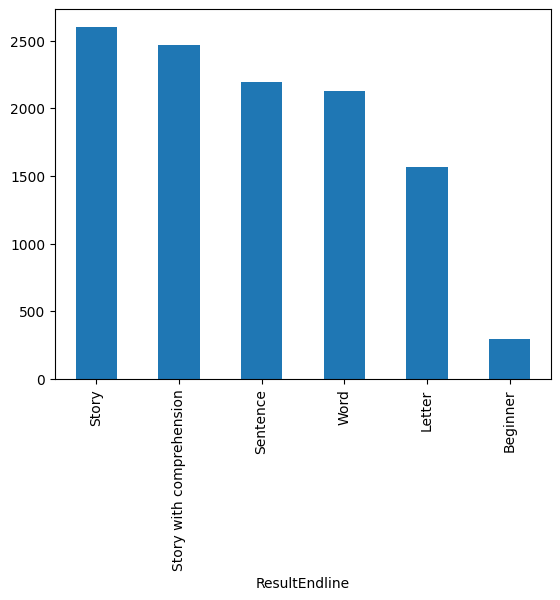

In [6]:
tcols = ['Baseline to Endline', 'Baseline_Endline',  'ComprehensionAchieved', 'StoryAchieved', 'ResultEndline']
for col in tcols:
    df[f'{col}'].value_counts().plot(kind='bar')
    plt.show()


In [7]:
df.groupby(['Baseline to Endline', 'Gender'])['Gender'].count()
# Same for both gender

Baseline to Endline  Gender 
Decrease             Female      245
                     Male        216
Increase             Female     5217
                     Male       4031
                     Unknown       2
Stayed The Same      Female      822
                     Male        715
Name: Gender, dtype: int64

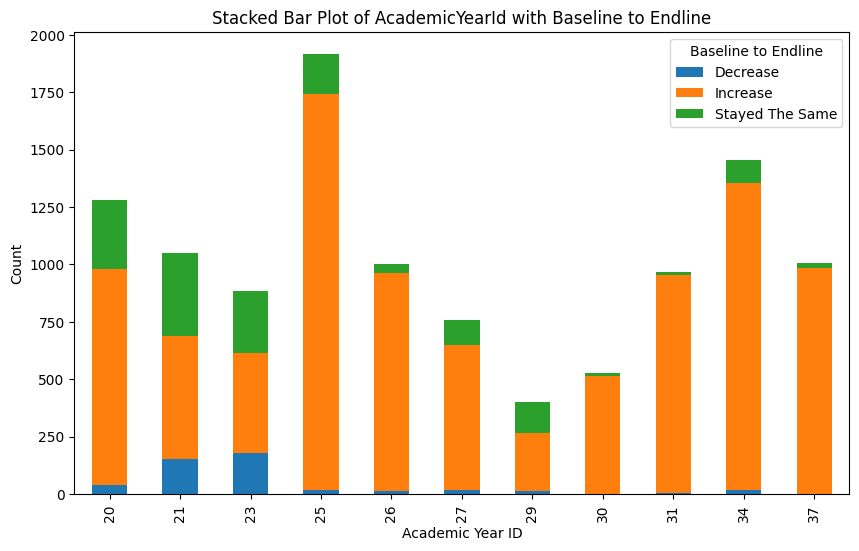

In [8]:
counts = df.groupby(['AcademicYearId', 'Baseline to Endline']).size().unstack()

counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of AcademicYearId with Baseline to Endline')
plt.xlabel('Academic Year ID')
plt.ylabel('Count')

plt.legend(title='Baseline to Endline')
plt.show()
# for all academic years the level is increased

## ug_fact_student_registrations

In [9]:
df2 = pd.read_excel('../../raw_data/Uganda - 2024 10 02(v1).xlsx', sheet_name='ug_fact_student_registrations').drop_duplicates()
df2.head()

,Gender,DeleteReasonId,CreatedOn,AcademicTermDetailsId,CuCStatus,AcademicYearId,ChildID,SchoolID,ClassID,IsActiveChildrenAcademicTable,CreatedOn_Child_Academic_Table,ModifiedOn_Child_Academic_Table,IsActiveChildTable,CreatedOn_Child_Table,ModifiedOn_Child_Table,LastName,Term,Reason,Year,Grade,Age,EoR1,EoR2,EoR3/Endline,DeleteReasonDinamic,IsCurrentChildrenAcademicTable,IsActiveChildrenAcademicTable - Copy,IsActiveChildTable - Copy,IsActiveSchool,IsActiveClass,ReachFilter,ParentTypeId,ParentType,Cycle,Domain,BaselineClass
0,Female,NaN,2023-11-29,1893,True,41,52426,211,4010,True,2023-11-29,2024-01-10,True,2023-11-29,NaT,NaN,1,NaN,2024,Grade 3,11.0,Yes,NaN,NaN,NaN,True,True,True,True,True,NaN,2.0,Mother,Literacy-Cycle 1,Literacy,No
1,Female,NaN,2023-11-29,1893,True,41,52428,211,4010,True,2023-11-29,2024-01-10,True,2023-11-29,NaT,NaN,1,NaN,2024,Grade 3,11.0,Yes,NaN,NaN,NaN,True,True,True,True,True,NaN,3.0,Guardian,Literacy-Cycle 1,Literacy,No
2,Female,NaN,2023-11-29,1893,True,41,52429,211,4010,True,2023-11-29,2024-01-10,True,2023-11-29,NaT,NaN,1,NaN,2024,Grade 3,10.0,Yes,NaN,NaN,NaN,True,True,True,True,True,NaN,2.0,Mother,Literacy-Cycle 1,Literacy,No
3,Female,NaN,2023-11-29,1893,True,41,52441,211,4010,True,2023-11-29,2024-01-10,True,2023-11-29,NaT,NaN,1,NaN,2024,Grade 3,9.0,Yes,NaN,NaN,NaN,True,True,True,True,True,NaN,3.0,Guardian,Literacy-Cycle 1,Literacy,No
4,Female,NaN,2023-11-29,1893,True,41,52443,211,4010,True,2023-11-29,2024-01-10,True,2023-11-29,NaT,NaN,1,NaN,2024,Grade 3,12.0,Yes,NaN,NaN,NaN,True,True,True,True,True,NaN,1.0,Father,Literacy-Cycle 1,Literacy,No


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40200 entries, 0 to 40200
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Gender                                40200 non-null  object        
 1   DeleteReasonId                        19182 non-null  float64       
 2   CreatedOn                             40200 non-null  datetime64[ns]
 3   AcademicTermDetailsId                 40200 non-null  int64         
 4   CuCStatus                             40200 non-null  bool          
 5   AcademicYearId                        40200 non-null  int64         
 6   ChildID                               40200 non-null  int64         
 7   SchoolID                              40200 non-null  int64         
 8   ClassID                               40200 non-null  int64         
 9   IsActiveChildrenAcademicTable         40200 non-null  bool          
 10  Cre

In [11]:
print(df2.groupby(['DeleteReasonId', 'Reason']).size())
print()
print(df2.groupby(['ParentType', 'ParentTypeId']).size())

DeleteReasonId  Reason                    
1.0             Transferred                   1436
2.0             Drop Out                       321
3.0             Died                             1
6.0             Others                        1322
12.0            Promoted                       577
13.0            Not Eligible                   412
14.0            Reading with Comprehension    7162
15.0            Duplicate                     1014
16.0            Child Not Struggling          1613
17.0            Graduated                     2276
dtype: int64

ParentType  ParentTypeId
Father      1.0             11461
Guardian    3.0             11800
Mother      2.0             13865
dtype: int64


In [12]:
# for ParentTypeId fill nan data by 0
df2.loc[:,'ParentTypeId'] = df2['ParentTypeId'].fillna(0)

display(df2[df2.DeleteReasonId==0][['DeleteReasonId', 'Reason']])
# for DeleteReasonId 0.0 == NaN
df2.loc[:, 'DeleteReasonId'] = df2['DeleteReasonId'].fillna(0)

,DeleteReasonId,Reason
12098,0.0,NaN
12099,0.0,NaN
12100,0.0,NaN
12101,0.0,NaN
12102,0.0,NaN
...,...,...
38926,0.0,NaN
38929,0.0,NaN
38930,0.0,NaN
38936,0.0,NaN


In [13]:
# Some columns are numeric representation of object columns, taken the numeric version of that features
# and based on data cictionary following columns were more useful than others
cols2 = ['ChildID','Term', 'Year', 'Grade', 'Age', 'EoR1', 'EoR2', 'EoR3/Endline', 'ParentTypeId', 'BaselineClass', 'SchoolID', 'ClassID',
         'IsActiveChildTable', 'IsCurrentChildrenAcademicTable', 'IsActiveSchool', 'IsActiveClass', 'CuCStatus', 'DeleteReasonId', 'AcademicYearId']
df2 = df2[cols2]
unique_vals(df2)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
9,BaselineClass,2,"[No, Yes]",object,0
1,Term,2,"[1, 2]",int64,0
16,CuCStatus,2,"[True, False]",bool,0
5,EoR1,2,"[Yes, No, nan]",object,4436
6,EoR2,2,"[nan, Yes, No]",object,8807
7,EoR3/Endline,2,"[nan, Yes, No]",object,8807
15,IsActiveClass,2,"[True, False]",bool,0
14,IsActiveSchool,2,"[True, False]",bool,0
12,IsActiveChildTable,2,"[True, False]",bool,0
13,IsCurrentChildrenAcademicTable,2,"[True, False]",bool,0


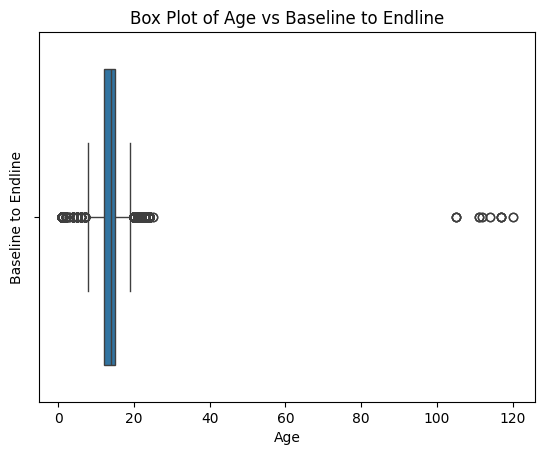

In [14]:
# Box plot of Age vs Baseline to Endline
sns.boxplot(data=df2, x='Age')
plt.title('Box Plot of Age vs Baseline to Endline')
plt.xlabel('Age')
plt.ylabel('Baseline to Endline')
plt.show()


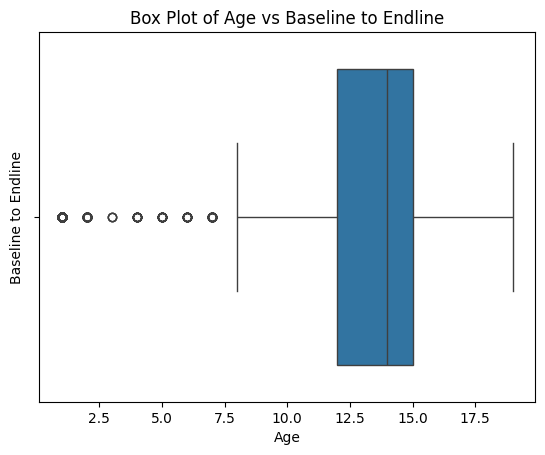

In [15]:
# drop outliers

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df2['Age'].quantile(0.25)
Q3 = df2['Age'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define the acceptable range for ages
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df2 = df2[(df2['Age'] <= upper_bound)]

sns.boxplot(data=df2, x='Age')
plt.title('Box Plot of Age vs Baseline to Endline')
plt.xlabel('Age')
plt.ylabel('Baseline to Endline')
plt.show()


In [16]:
unique_vals(df2)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
9,BaselineClass,2,"[No, Yes]",object,0
1,Term,2,"[1, 2]",int64,0
5,EoR1,2,"[Yes, No, nan]",object,4367
6,EoR2,2,"[nan, Yes, No]",object,8708
7,EoR3/Endline,2,"[nan, Yes, No]",object,8708
16,CuCStatus,2,"[True, False]",bool,0
15,IsActiveClass,2,"[True, False]",bool,0
12,IsActiveChildTable,2,"[True, False]",bool,0
13,IsCurrentChildrenAcademicTable,2,"[True, False]",bool,0
14,IsActiveSchool,2,"[True, False]",bool,0


In [17]:
# fill other object columns with 0
df2.fillna('null', inplace=True)

In [18]:
merged_df = pd.merge(
    df, 
    df2, 
    left_on=['ChildrenId', 'AcademicYearId'], 
    right_on=['ChildID', 'AcademicYearId'], 
    how='inner'
)
merged_df.drop('ChildID', axis=1, inplace=True)  # If needed
merged_df.shape

(11134, 32)

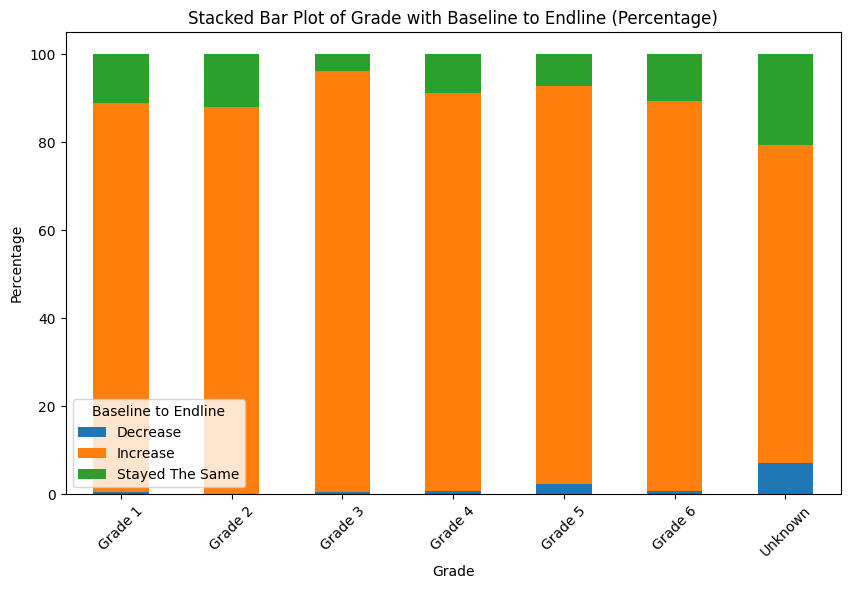

In [19]:

counts = merged_df.groupby(['Grade', 'Baseline to Endline']).size().unstack()

# Calculate percentages
percentage = counts.divide(counts.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart with percentages
percentage.plot(kind='bar', stacked=True, figsize=(10,6))

# Adding labels and title
plt.ylabel('Percentage')
plt.legend(title='Baseline to Endline')
plt.title('Stacked Bar Plot of Grade with Baseline to Endline (Percentage)')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# for children whose class is unknown, level is deacreased

DeleteReasonId
0.0     7655
14.0    2340
6.0      310
1.0      261
12.0     205
15.0     142
17.0     136
2.0       64
16.0      20
13.0       1
Name: count, dtype: int64


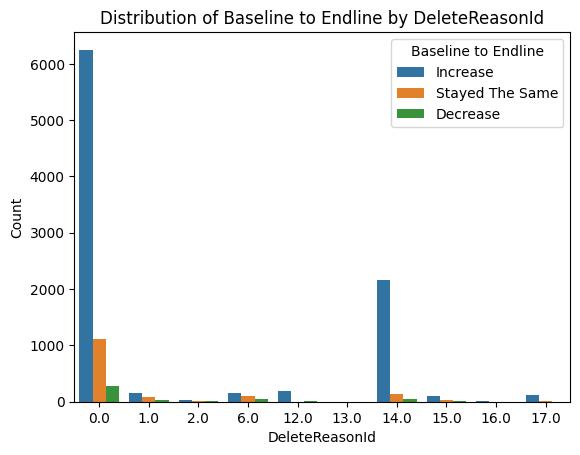

In [20]:
# Count of each ParentType
parent_counts = merged_df['DeleteReasonId'].value_counts()
print(parent_counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='DeleteReasonId', hue='Baseline to Endline')
plt.title('Distribution of Baseline to Endline by DeleteReasonId')
plt.ylabel('Count')
plt.show()

# No difference based on Parent type

The majority of students prefer not to provide a reason for dropping the course(#0). However, among the reasons given, #14.0 (Reading with Comprehension) was the most common. But for both #0 and #14 the level is increased

ParentTypeId
3.0    3538
2.0    3147
1.0    3051
0.0    1398
Name: count, dtype: int64


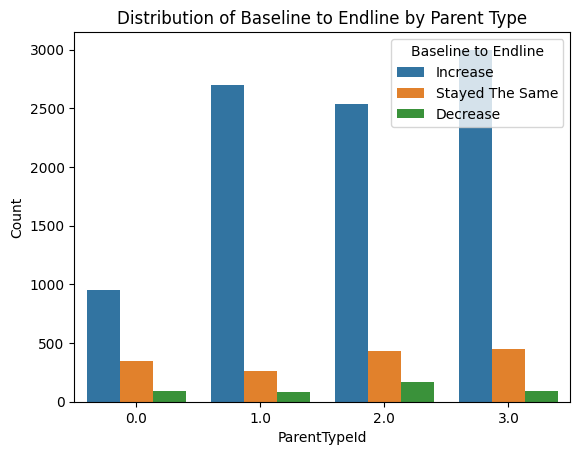

In [21]:
# Count of each ParentType
parent_counts = merged_df['ParentTypeId'].value_counts()
print(parent_counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='ParentTypeId', hue='Baseline to Endline')
plt.title('Distribution of Baseline to Endline by Parent Type')
plt.ylabel('Count')
plt.show()



There is no difference in the change in student achievement levels depending on the parent type.

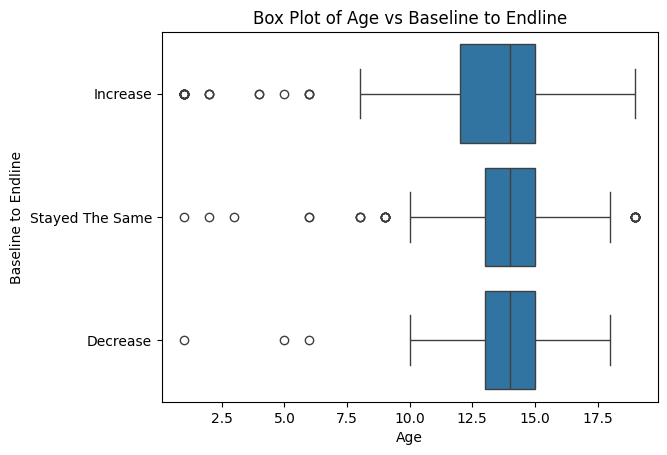

In [22]:
# Box plot of Age vs Baseline to Endline
sns.boxplot(data=merged_df, x='Age', y='Baseline to Endline')
plt.title('Box Plot of Age vs Baseline to Endline')
plt.xlabel('Age')
plt.ylabel('Baseline to Endline')
plt.show()


Same Age ranges for all levels

/var/folders/_f/s0xx4_bj711c1h8k9b5vjhgm0000gn/T/ipykernel_93945/4239554365.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = merged_df.groupby(['AgeGroup', 'Baseline to Endline']).size().unstack()


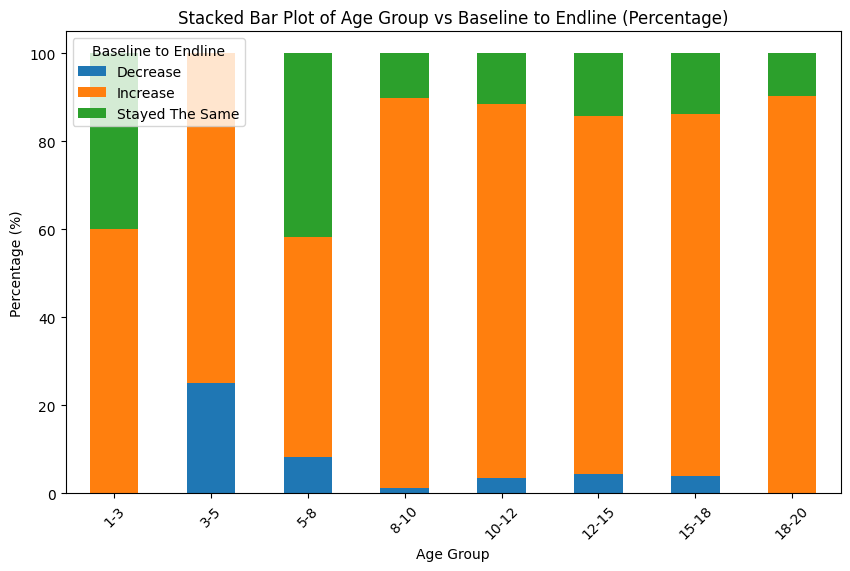

In [23]:
# # Binning Age into categories
bins = [1, 3, 5,8, 10, 12, 15, 18, 20]  # Adjust based on your data range
labels = ['1-3','3-5','5-8', '8-10', '10-12', '12-15', '15-18', '18-20']
merged_df['AgeGroup'] = pd.cut(merged_df['Age'], bins=bins, labels=labels)

# Group by AgeGroup and Baseline to Endline, then normalize to get percentages
counts = merged_df.groupby(['AgeGroup', 'Baseline to Endline']).size().unstack()

# Convert the counts to percentages
percentage_counts = counts.div(counts.sum(axis=1), axis=0) * 100

# Create a stacked bar plot with percentages
percentage_counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of Age Group vs Baseline to Endline (Percentage)')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.legend(title='Baseline to Endline')
plt.xticks(rotation=45)
plt.show()

merged_df.drop('AgeGroup', axis=1, inplace=True)

The decrease rate among students aged 3-5 was higher than that of other age groups.

## ug_fact_student_attendance

In [24]:
df3 = pd.read_excel(
    '../../raw_data/Uganda - 2024 10 02(v1).xlsx', 
    sheet_name='ug_fact_student_attendance',
    usecols=['ChildrenId', 'AcademicYearId', 'AcademicYearName', 'StudentIsPresent']
)
display(df3.head())
print(df3.shape)

,StudentIsPresent,ChildrenId,AcademicYearId,AcademicYearName
0,True,28503,25.0,2022-PPL-Literacy-CuC Cycle 1
1,True,28504,25.0,2022-PPL-Literacy-CuC Cycle 1
2,True,28505,25.0,2022-PPL-Literacy-CuC Cycle 1
3,True,28506,25.0,2022-PPL-Literacy-CuC Cycle 1
4,True,28507,25.0,2022-PPL-Literacy-CuC Cycle 1


(949785, 4)


In [25]:
# Calculate attendance rate
df3['AttendanceRate'] = df3.groupby(['ChildrenId', 'AcademicYearId'])['StudentIsPresent'].transform('mean')
df3.drop('StudentIsPresent', axis=1, inplace=True)
# Drop duplicated columns
df3 = df3.drop_duplicates()
df3.shape

(36382, 4)

In [26]:
# merge two sheets based on ChildID
merged_df = pd.merge(
    merged_df, 
    df3, 
    left_on=['ChildrenId', 'AcademicYearId'], 
    right_on=['ChildrenId', 'AcademicYearId'], 
    how='inner'
)

merged_df.shape

(8979, 34)

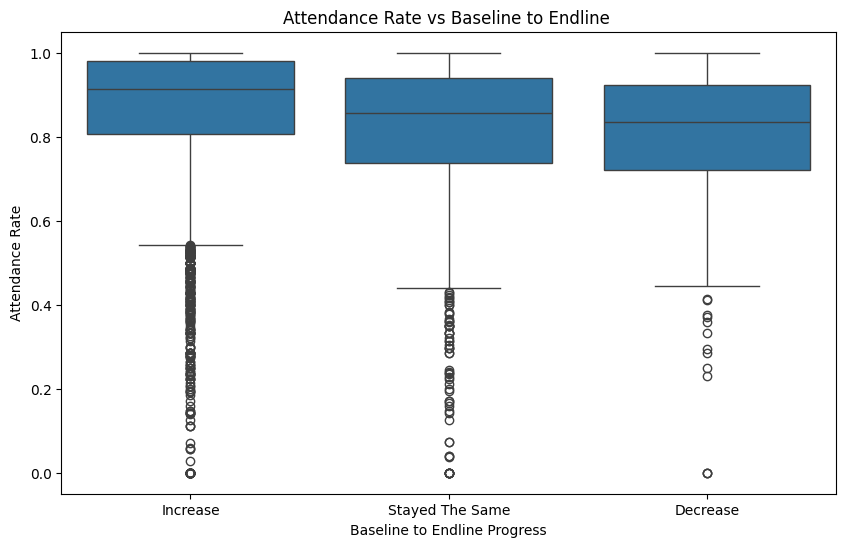

In [51]:
# Plot attendance rates for each baseline-to-endline transition
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Baseline to Endline', y='AttendanceRate')

# Add titles and labels
plt.title('Attendance Rate vs Baseline to Endline ')
plt.xlabel('Baseline to Endline Progress')
plt.ylabel('Attendance Rate')

plt.show()

In [27]:
merged_df.to_csv('data/merged_Uganda.csv', index=True)
# merged_df.to_excel('data/merged_Uganda_nans.xlsx', index=True)

AcademicYearId
25    1933
34    1449
21     936
26     901
23     797
31     743
27     738
37     658
30     430
29     394
Name: count, dtype: int64


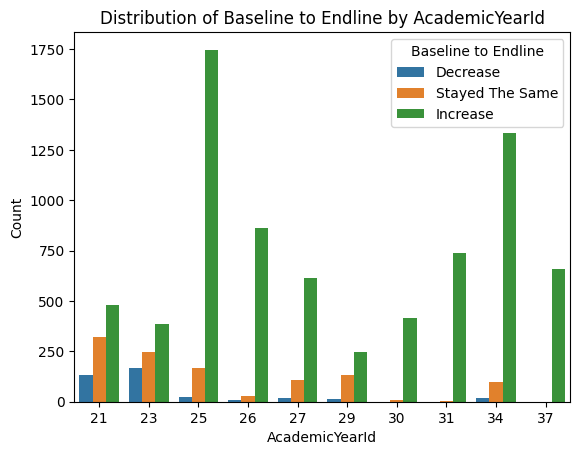

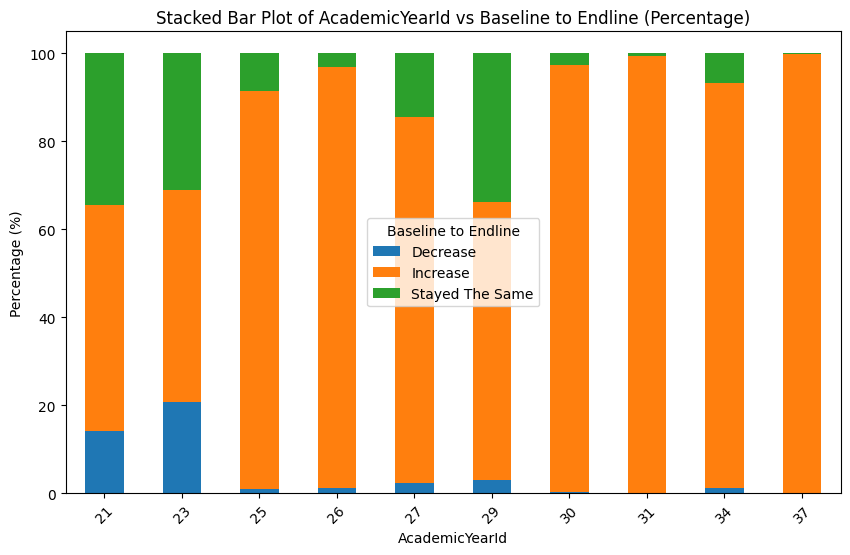

In [28]:
# Count of each ParentType
counts = merged_df['AcademicYearId'].value_counts()
print(counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='AcademicYearId', hue='Baseline to Endline')
plt.title('Distribution of Baseline to Endline by AcademicYearId')
plt.ylabel('Count')
plt.show()


counts = merged_df.groupby(['AcademicYearId', 'Baseline to Endline']).size().unstack()
# Convert the counts to percentages
percentage_counts = counts.div(counts.sum(axis=1), axis=0) * 100

# Create a stacked bar plot with percentages
percentage_counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of AcademicYearId vs Baseline to Endline (Percentage)')
plt.xlabel('AcademicYearId')
plt.ylabel('Percentage (%)')
plt.legend(title='Baseline to Endline')
plt.xticks(rotation=45)
plt.show()

Academic cycles #21.0, #23.0, #25.0, #27.0 have more students than the others. However, cycles #21.0, #23.0show higher decrease rates. 

In contrast, other cycles, having fewer students, exhibit improved levels.

- 21.0  -            2022-Baana-Literacy-CuC Cycle 1     
- 23.0   -          2022-Baana-Literacy-CuC Cycle 2      
- 25.0     -        2022-PPL-Literacy-CuC Cycle 1         
- 27.0      -      2023-PPL-Literacy-CuC Cycle 1       


## additional data

In [29]:
df4 = pd.read_csv( '../../raw_data/Uganda-Additional Data - 2024 10 15(Literacy).csv', encoding='ISO-8859-1').drop_duplicates()
df4.head()

/var/folders/_f/s0xx4_bj711c1h8k9b5vjhgm0000gn/T/ipykernel_93945/1215009674.py:1: DtypeWarning: Columns (2,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv( '../../raw_data/Uganda-Additional Data - 2024 10 15(Literacy).csv', encoding='ISO-8859-1').drop_duplicates()


,AcademicYearId,SchoolId,ClassId,ChildrenId,ChildrenGender,ChildrenGrade,ChildrenDateOfBirth,ChildrenAge,SubmissionDateTime,FloorMaterial,RoofMaterial,WallMaterial,IsElectricityAvailable?,IsRadioTVAvailable?,IsTelephoneAvailable?,IsBikeAvailable?,Vision,Hearing,Walking/Climbing,MemoryConcentration,Selfcare,CommunicationIssue,Safety Status Category,IsCUCSatisfied?,WillingnessInCUC?,...,SomeoneToTalkWhenStress,TellFamilyWhenStress,FeelingSad,HowResolveProblem,WhoResolveProblem,ReadingMaterialsAtHome,FamilyRead,FamilyReadStory,ReadAtHomeLastWeek,FamilySupportHomeworkLastweek,BarriersToLearn,OtherBarriersToLearn,ReadingAssessmentsRecords,ChildTeenageMother?,Nationality,CurrentClass,Village,Year,Project,Cycle,AssessmentResultAchieved,G_AcademicYearId,G_SchoolID,G_ChildrenId,WalikuCountry
0,27,150,NaN,28977,Unknown,Unknown,NaN,NaN,11/15/2022 7:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_safe,10.0,VeryLikely,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,PPL,1,Letter,UG-27,UG-150,UG-28977,Waliku
1,27,150,NaN,28980,Unknown,Unknown,NaN,NaN,11/15/2022 7:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_safe,10.0,VeryLikely,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,PPL,1,Letter,UG-27,UG-150,UG-28980,Waliku
2,27,150,NaN,28987,Unknown,Unknown,NaN,NaN,11/15/2022 7:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_safe,10.0,VeryLikely,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,PPL,1,Letter,UG-27,UG-150,UG-28987,Waliku
3,27,150,NaN,28989,Unknown,Unknown,NaN,NaN,11/15/2022 7:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_safe,10.0,VeryLikely,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,PPL,1,Letter,UG-27,UG-150,UG-28989,Waliku
4,27,150,NaN,28990,Unknown,Unknown,NaN,NaN,11/15/2022 7:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_safe,10.0,VeryLikely,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,PPL,1,Letter,UG-27,UG-150,UG-28990,Waliku


In [30]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105134 entries, 0 to 105210
Data columns (total 74 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   AcademicYearId                 105134 non-null  int64  
 1   SchoolId                       105134 non-null  int64  
 2   ClassId                        77377 non-null   object 
 3   ChildrenId                     105134 non-null  int64  
 4   ChildrenGender                 105134 non-null  object 
 5   ChildrenGrade                  105134 non-null  object 
 6   ChildrenDateOfBirth            16513 non-null   object 
 7   ChildrenAge                    12322 non-null   float64
 8   SubmissionDateTime             105133 non-null  object 
 9   FloorMaterial                  16488 non-null   object 
 10  RoofMaterial                   16751 non-null   object 
 11  WallMaterial                   16751 non-null   object 
 12  IsElectricityAvailable?        1675

In [31]:
df4['Vision'].value_counts()
# some labels have same meaning:

Vision
No difficulty          8007
No_difficulty          5522
Some_difficulty         256
Some difficulty         174
Don't_know               84
Lot_difficulty           37
Refused                  14
A lot of difficulty       7
Name: count, dtype: int64

In [32]:
for col in ['Vision', 'Hearing','Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']:
    df4.loc[df4[col] == 'No_difficulty', col] = 'No difficulty'
    df4.loc[df4[col] == 'Some_difficulty', col] = 'Some difficulty'
    df4.loc[df4[col] == 'Lot_difficulty', col] = 'A lot of difficulty'
    df4.loc[df4[col] == 'Cannot_do_at_all', col] = 'Cannot do at all'

    print(df4[col].value_counts())
    print()

Vision
No difficulty          13529
Some difficulty          430
Don't_know                84
A lot of difficulty       44
Refused                   14
Name: count, dtype: int64

Hearing
No difficulty          8230
Some difficulty         224
Don't_know               54
Refused                   3
A lot of difficulty       2
Name: count, dtype: int64

Walking/Climbing
No difficulty          13465
Some difficulty          512
Don't_know                69
A lot of difficulty       20
Refused                   13
Cannot do at all           3
Name: count, dtype: int64

MemoryConcentration
No difficulty          10796
Some difficulty         1636
A lot of difficulty      118
Don't_know                70
Refused                    5
Name: count, dtype: int64

Selfcare
No difficulty          10344
Some difficulty          380
Don't_know                83
A lot of difficulty       11
Cannot do at all           4
Refused                    3
Name: count, dtype: int64

CommunicationIssue
No diff

In [33]:
for col in ['MemoryConcentration', 'Selfcare', 'CommunicationIssue']:

    print(df4[col].value_counts())
    print()

MemoryConcentration
No difficulty          10796
Some difficulty         1636
A lot of difficulty      118
Don't_know                70
Refused                    5
Name: count, dtype: int64

Selfcare
No difficulty          10344
Some difficulty          380
Don't_know                83
A lot of difficulty       11
Cannot do at all           4
Refused                    3
Name: count, dtype: int64

CommunicationIssue
No difficulty          9926
Some difficulty         772
Don't_know               87
A lot of difficulty      30
Refused                   7
Cannot do at all          1
Name: count, dtype: int64



In [34]:
df4['Disability'] = df4.apply(
    lambda row: 'With Disability' if any(row[col] in ['Some difficulty', 'A lot of difficulty'] for col in ['Vision', 'Hearing', 'Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']) else 'Without Disability' ,
    axis=1
)

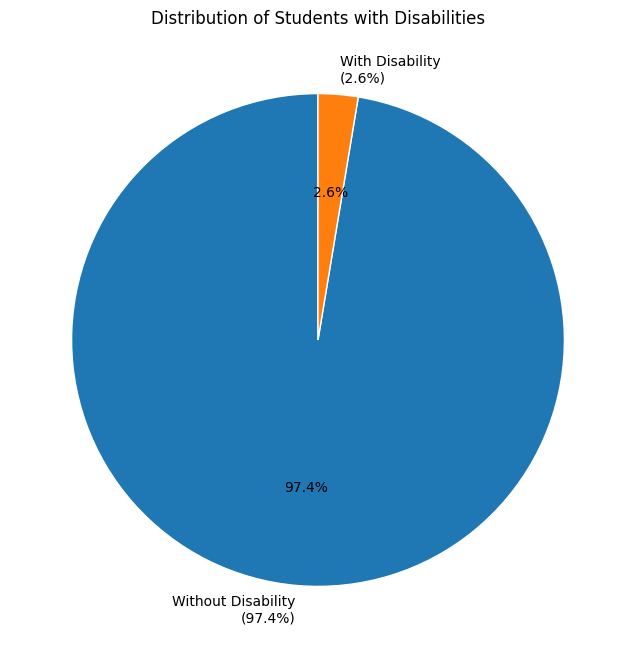

In [35]:
disability_counts = df4['Disability'].value_counts()
disability_percentages = df4['Disability'].value_counts(normalize=True) * 100

labels = [f'{idx}\n({val:.1f}%)' for idx, val in disability_percentages.items()]

plt.figure(figsize=(10, 8))
plt.pie(disability_counts, labels=labels, autopct='%1.1f%%',
        startangle=90, wedgeprops={'edgecolor': 'white'})

plt.title('Distribution of Students with Disabilities')
plt.show()

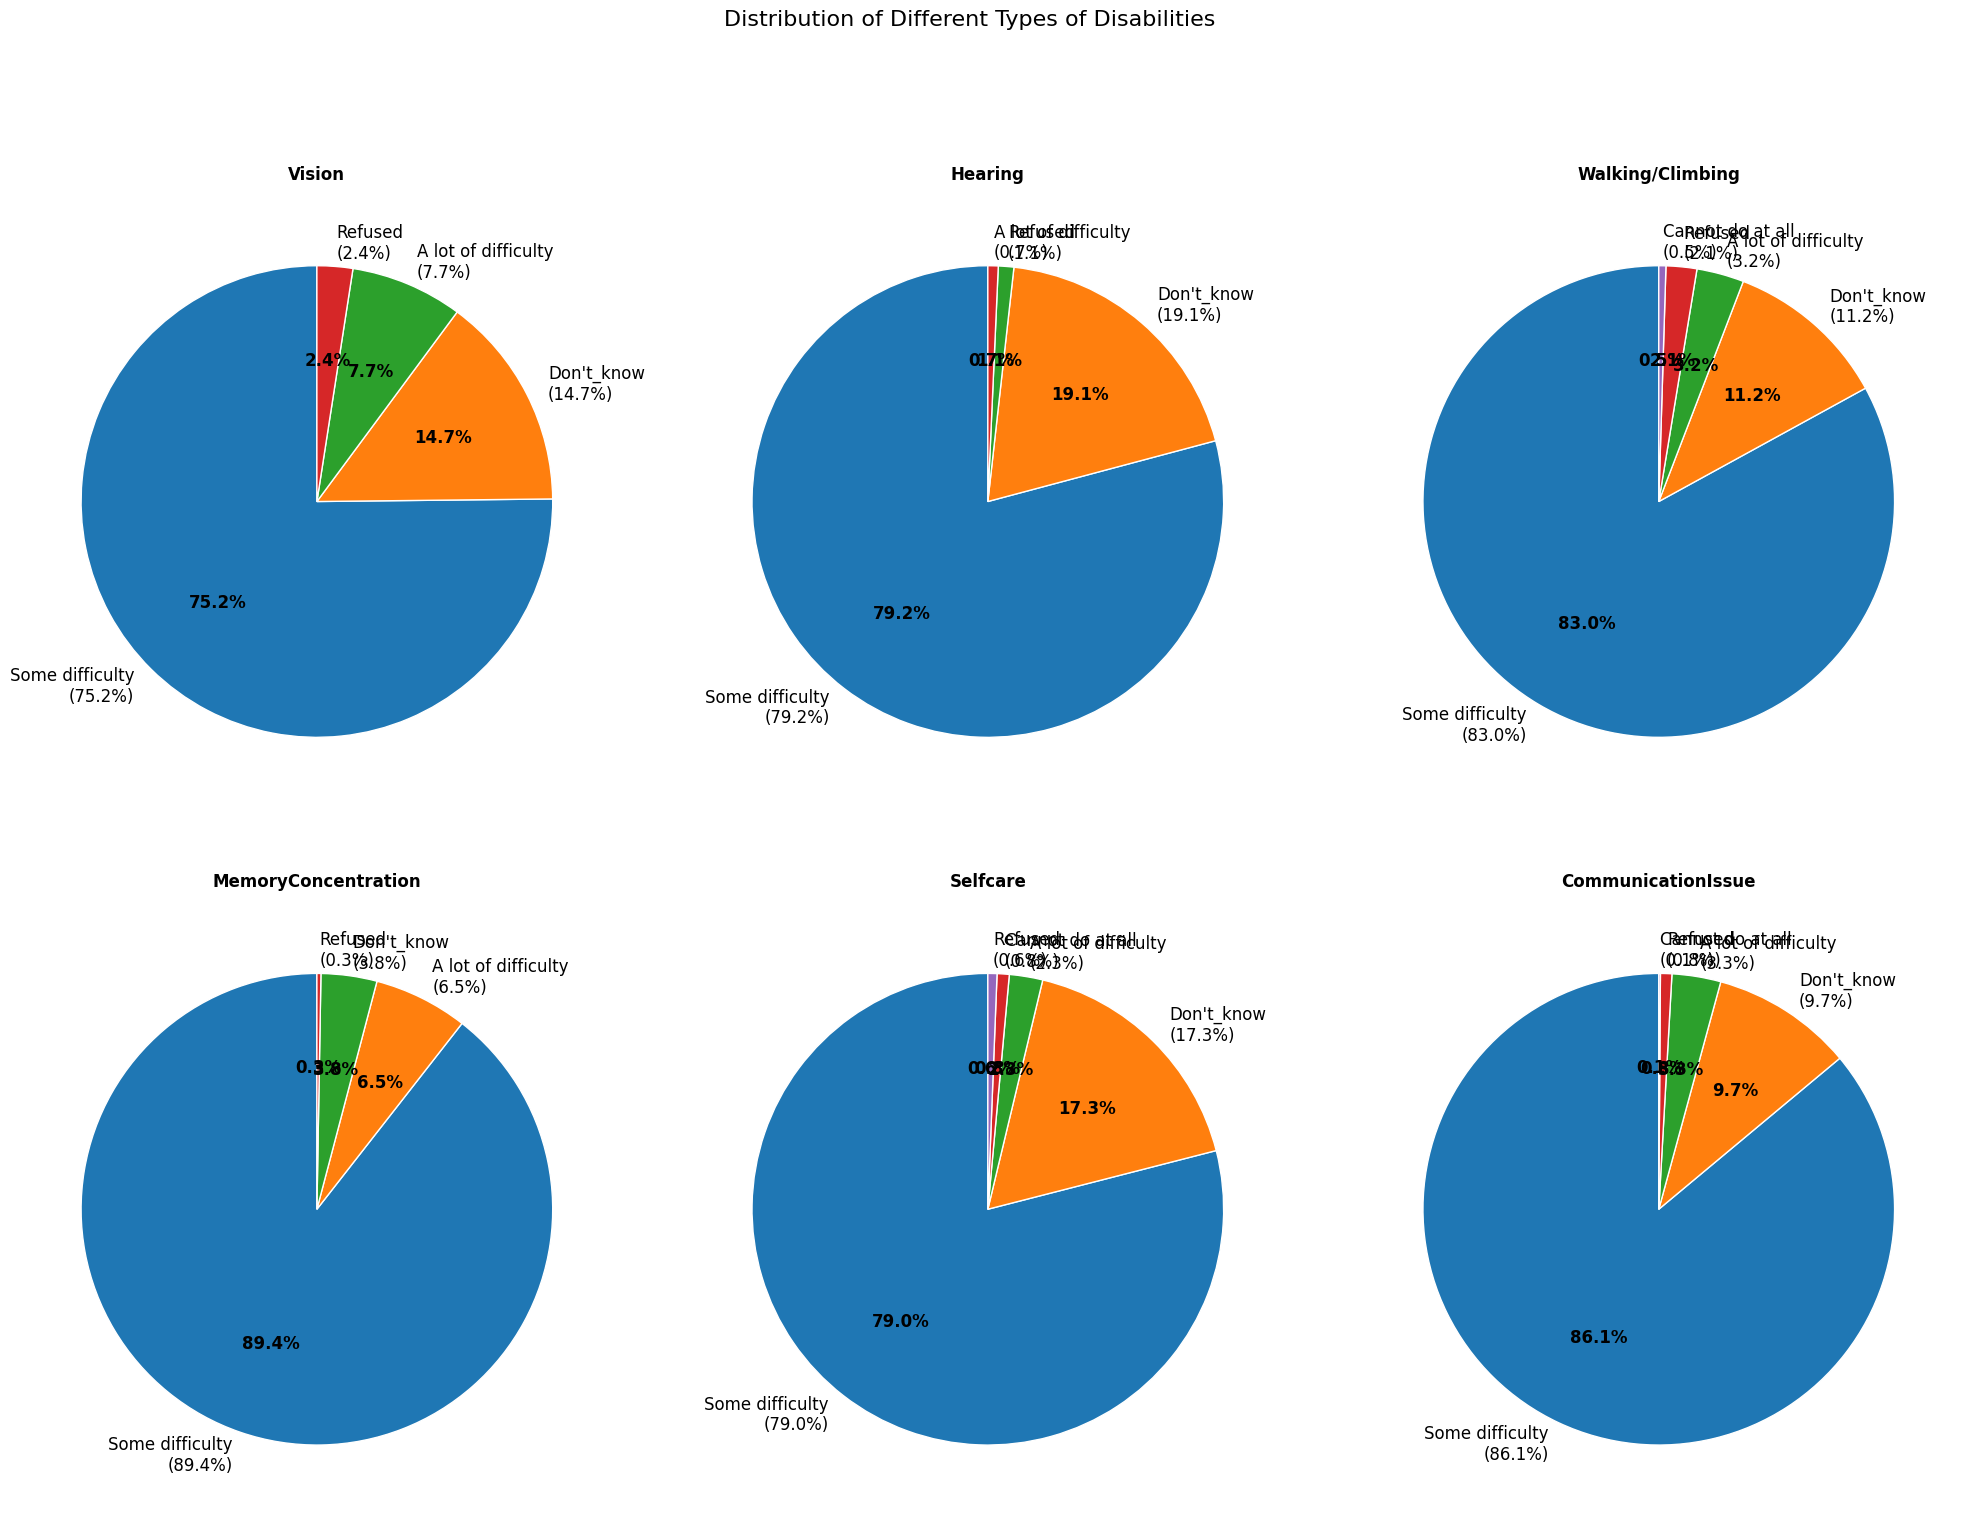

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Distribution of Different Types of Disabilities', fontsize=16, y=1.05)

axes = axes.flatten()

disability_cols = ['Vision', 'Hearing', 'Walking/Climbing', 
                  'MemoryConcentration', 'Selfcare', 'CommunicationIssue']

for i, col in enumerate(disability_cols):
    values = df4[df4[col]!='No difficulty'][col].value_counts()
    percentages = df4[df4[col]!='No difficulty'][col].value_counts(normalize=True) * 100
    
    labels = [f'{idx}\n({val:.1f}%)' for idx, val in percentages.items()]

    wedges, texts, autotexts = axes[i].pie(values, labels=labels, 
                                          autopct='%1.1f%%', startangle=90,
                                          wedgeprops={'edgecolor': 'white'})

    plt.setp(autotexts, size=12, weight="bold")
    plt.setp(texts, size=12)
    
    axes[i].set_title(col, pad=20, size=12, weight='bold')

plt.tight_layout()
plt.show()

In [37]:
# df4.to_excel('../../OneDrive_1_2024-10-4/Uganda-Additional Data.xlsx')

In [38]:
#  fillna for learners with disabilities
df4[['Vision', 'Hearing','Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']] =  df4[['Vision', 'Hearing','Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']].fillna('null')

In [39]:
# drop duplicated columns with other dataset
df4 = df4.drop(['ChildrenDateOfBirth', 'ClassId', 'Class', 'G_ChildrenId', 'G_AcademicYearId', 'Year','Cycle', 'SchoolId',  'ChildrenGender',
       'ChildrenGrade', 'ChildrenDateOfBirth', 'ChildrenAge','SubmissionDateTime', 'G_SchoolID', 'KOBOId' ], axis=1)

# drop columns where 90% of data is nan
df4 = df4.dropna(thresh=len(df4) * 0.1, axis=1)


In [40]:
display(unique_vals(df4))

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
25,WalikuCountry,1,[Waliku],object,0
26,Disability,2,"[Without Disability, With Disability]",object,0
23,Project,3,"[PPL, Baana, Hempel]",object,0
5,IsElectricityAvailable?,3,"[nan, No, Yes, Don't_Know]",object,88383
6,IsRadioTVAvailable?,3,"[nan, Yes, No, Don't_Know]",object,88383
7,IsTelephoneAvailable?,3,"[nan, Yes, No, Don't_Know]",object,88383
8,IsBikeAvailable?,3,"[nan, Yes, No, Don't_Know]",object,91044
2,FloorMaterial,4,"[nan, Mud, Tile_cement, Tile/Cement, Don't_know]",object,88646
19,SafeAtSchool,5,"[nan, very_safe, Safe, Neutral, Very Safe, Un ...",object,86001
24,AssessmentResultAchieved,6,"[Letter, Beginner, Sentence, Story, Story with...",object,80


In [41]:
# contains only one value
df4.drop('WalikuCountry', axis=1, inplace=True)

In [42]:
df4['IsCUCSatisfied?'].value_counts()

IsCUCSatisfied?
5.0     19254
10.0    14176
4.0     10342
9.0      7790
8.0      4639
7.0      2333
3.0      1991
6.0      1401
2.0       666
1.0       458
Name: count, dtype: int64

In [43]:
df4[['IsCUCSatisfied?', 'ReadingAssessmentsRecords']] = df4[['IsCUCSatisfied?', 'ReadingAssessmentsRecords']].fillna(0.0)
df4.fillna('null', inplace=True)

In [44]:
df4.shape

(105134, 26)

In [45]:
df4['ChildrenId'].nunique()

27384

In [46]:
# merge two sheets based on ChildID
merged_df2 = pd.merge(
    merged_df, 
    df4, 
    left_on=['ChildrenId', 'AcademicYearId'], 
    right_on=['ChildrenId', 'AcademicYearId'], 
    how='inner'
)

merged_df2.shape

(35436, 58)

In [47]:
# All learners' SafeAtSchool is not given
print(merged_df2.SafeAtSchool.value_counts())
print(merged_df2.SafeAtHome.value_counts())
print(merged_df2.LastCuCCycleStatus.value_counts())

SafeAtSchool
null         33298
Very Safe     1806
Safe           327
Neutral          5
Name: count, dtype: int64
SafeAtHome
null         33298
Very Safe     1708
Safe           423
Neutral          7
Name: count, dtype: int64
LastCuCCycleStatus
null    34722
No        714
Name: count, dtype: int64


In [48]:
# df4[['Vision', 'Hearing', 'Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']] = df4[
#     ['Vision', 'Hearing', 'Walking/Climbing', 'MemoryConcentration', 'Selfcare', 'CommunicationIssue']
# ].replace('0', pd.NA)

# merged_df2.to_excel('data/merged_Uganda_with_additional_nans.xlsx', index=True)

merged_df2.to_csv('data/merged_Uganda_with_additional.csv', index=True, quoting=1)

# Data type transformation

In [49]:
merged_df2[['AcademicYearName', 'AcademicYearId']].groupby(['AcademicYearName', 'AcademicYearId']).size()
# AcademicYearId column is the numeric representation of AcademicYearName columnun

AcademicYearName                  AcademicYearId
2022-Baana-Literacy-CuC Cycle 1   21                4476
2022-Baana-Literacy-CuC Cycle 2   23                3142
2022-Hempel-Literacy-CuC Cycle 1  26                3556
2022-PPL-Literacy-CuC Cycle 1     25                5851
2023-Baana-Literacy-CuC Cycle 1   29                1595
2023-Hempel-Literacy-Cycle 1      30                1613
2023-Hempel-Literacy-Cycle 2      31                3447
2023-Hempel-Literacy-Cycle3       37                2852
2023-PPL-Literacy-CuC Cycle 1     27                3041
2023-PPL-Literacy-CuC Cycle 2     34                5863
dtype: int64

In [50]:
merged_df2.drop('AcademicYearName', axis=1, inplace=True)

In [51]:
unique_vals(merged_df2,  True, True)
# categorical columns

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
23,BaselineClass,1,[No],object,0
56,Disability,2,"[Without Disability, With Disability]",object,0
52,LastCuCCycleStatus,2,"[0, No]",object,0
19,EoR1,2,"[No, Yes]",object,0
20,EoR2,2,"[Yes, No]",object,0
21,EoR3/Endline,2,"[Yes, No]",object,0
54,Project,3,"[Hempel, PPL, Baana]",object,0
41,Hearing,3,"[0, No difficulty, Some difficulty]",object,0
7,Baseline to Endline,3,"[Increase, Stayed The Same, Decrease]",object,0
13,Gender,3,"[Male, Female, Unknown]",object,0


In [52]:
object_columns = unique_vals(merged_df2,  True, True).col_name.values
# encode categorical columns to numbers
ordinal_encoder = OrdinalEncoder()
merged_df2.loc[:, object_columns] = ordinal_encoder.fit_transform(merged_df2[object_columns])

In [53]:
import json
mappings = {
    column: dict(zip(categories, range(len(categories))))
    for column, categories in zip(merged_df2[object_columns].columns, ordinal_encoder.categories_)
}

#  Save the dictionary to a JSON file
with open('mappings/uganda.json', 'w') as json_file:
    json.dump(mappings, json_file, indent=4)

# Loading:
# with open('path.json', 'r') as json_file:
#     loaded_mappings = json.load(json_file)
mappings

{'BaselineClass': {'No': 0},
 'Disability': {'With Disability': 0, 'Without Disability': 1},
 'LastCuCCycleStatus': {'0': 0, 'No': 1},
 'EoR1': {'No': 0, 'Yes': 1},
 'EoR2': {'No': 0, 'Yes': 1},
 'EoR3/Endline': {'No': 0, 'Yes': 1},
 'Project': {'Baana': 0, 'Hempel': 1, 'PPL': 2},
 'Hearing': {'0': 0, 'No difficulty': 1, 'Some difficulty': 2},
 'Baseline to Endline': {'Decrease': 0, 'Increase': 1, 'Stayed The Same': 2},
 'Gender': {'Female': 0, 'Male': 1, 'Unknown': 2},
 'SafeAtHome': {'0': 0, 'Neutral': 1, 'Safe': 2, 'Very Safe': 3},
 'SafeAtSchool': {'0': 0, 'Neutral': 1, 'Safe': 2, 'Very Safe': 3},
 'IsBikeAvailable?': {'0': 0, "Don't_Know": 1, 'No': 2, 'Yes': 3},
 'IsTelephoneAvailable?': {'0': 0, "Don't_Know": 1, 'No': 2, 'Yes': 3},
 'IsRadioTVAvailable?': {'0': 0, "Don't_Know": 1, 'No': 2, 'Yes': 3},
 'IsElectricityAvailable?': {'0': 0, "Don't_Know": 1, 'No': 2, 'Yes': 3},
 'Baseline to Round 1': {'0': 0,
  'Decrease': 1,
  'Increase': 2,
  'Stayed The Same': 3},
 'Round 1 to Rou

In [54]:
# # Find boolean columns and convert to int
# bool_columns = merged_df.select_dtypes(include='bool').columns
# merged_df[bool_columns] = merged_df[bool_columns].astype(int)
# unique_vals(merged_df)

In [55]:
# only one value for CuCStatus
merged_df2.drop('CuCStatus', axis=1, inplace=True)
merged_df2.drop('BaselineClass', axis=1, inplace=True)

In [56]:
unique_vals(merged_df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
30,CuCStatus,1,[True],bool,0
23,BaselineClass,1,[No],object,0
28,IsActiveSchool,2,"[True, False]",bool,0
27,IsCurrentChildrenAcademicTable,2,"[True, False]",bool,0
26,IsActiveChildTable,2,"[True, False]",bool,0
21,EoR3/Endline,2,"[Yes, No]",object,0
20,EoR2,2,"[Yes, No]",object,0
19,EoR1,2,"[No, Yes]",object,0
29,IsActiveClass,2,"[True, False]",bool,0
11,StoryAchieved,2,"[False, True]",bool,0


# Correlation analysis

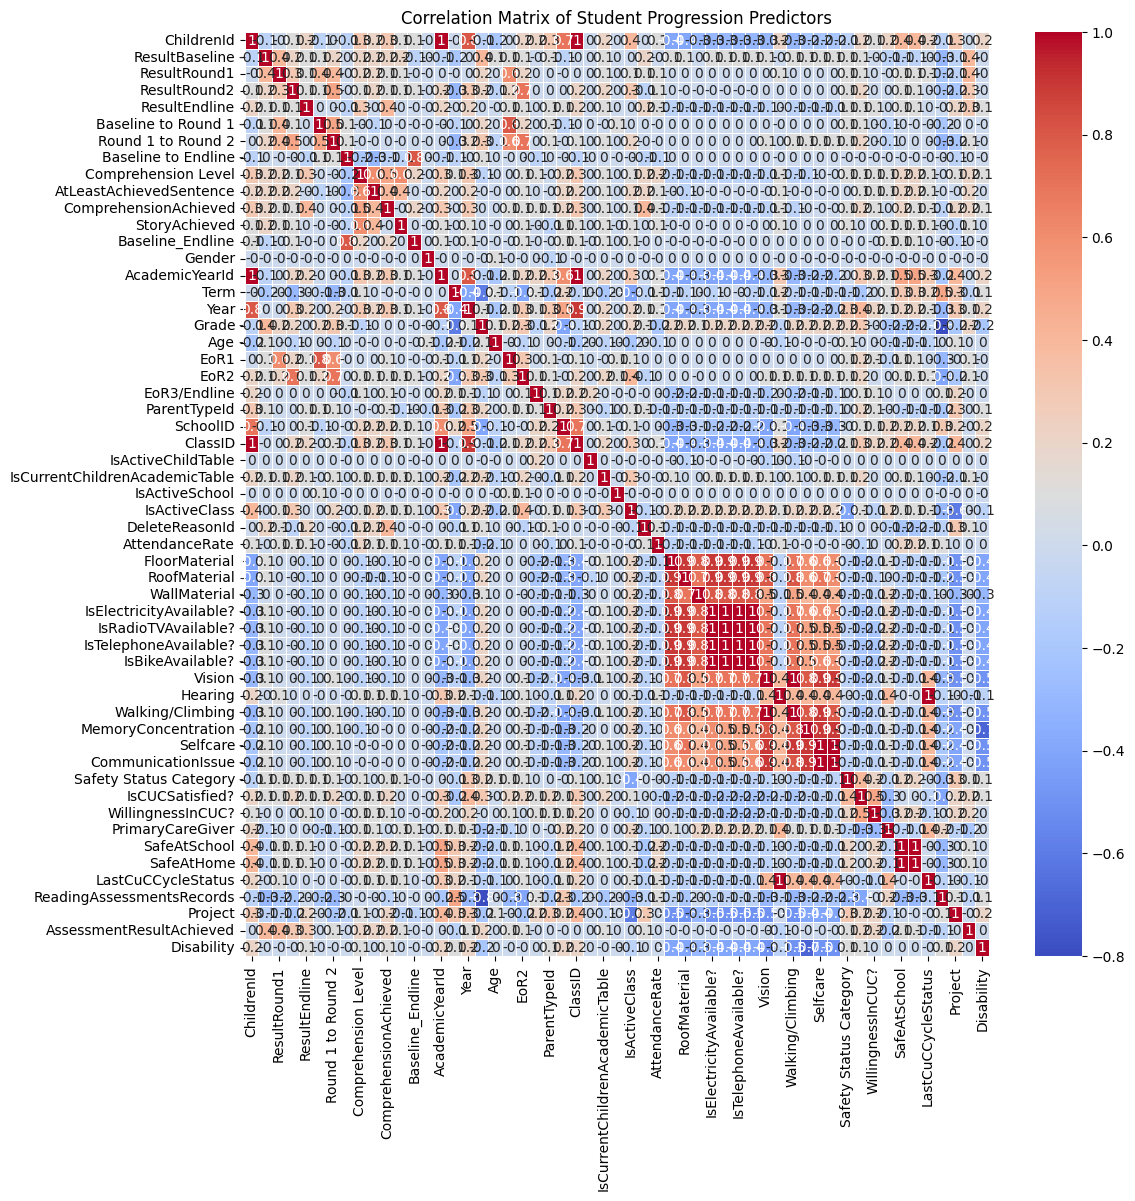

In [57]:
merged_df2.rename(columns={'Completing Result Baseline to Endline-Story/Comprehension Level': 'Comprehension Level'}, inplace=True)

# correlation matrix
corr_matrix = merged_df2.corr().round(1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Student Progression Predictors')
plt.show()

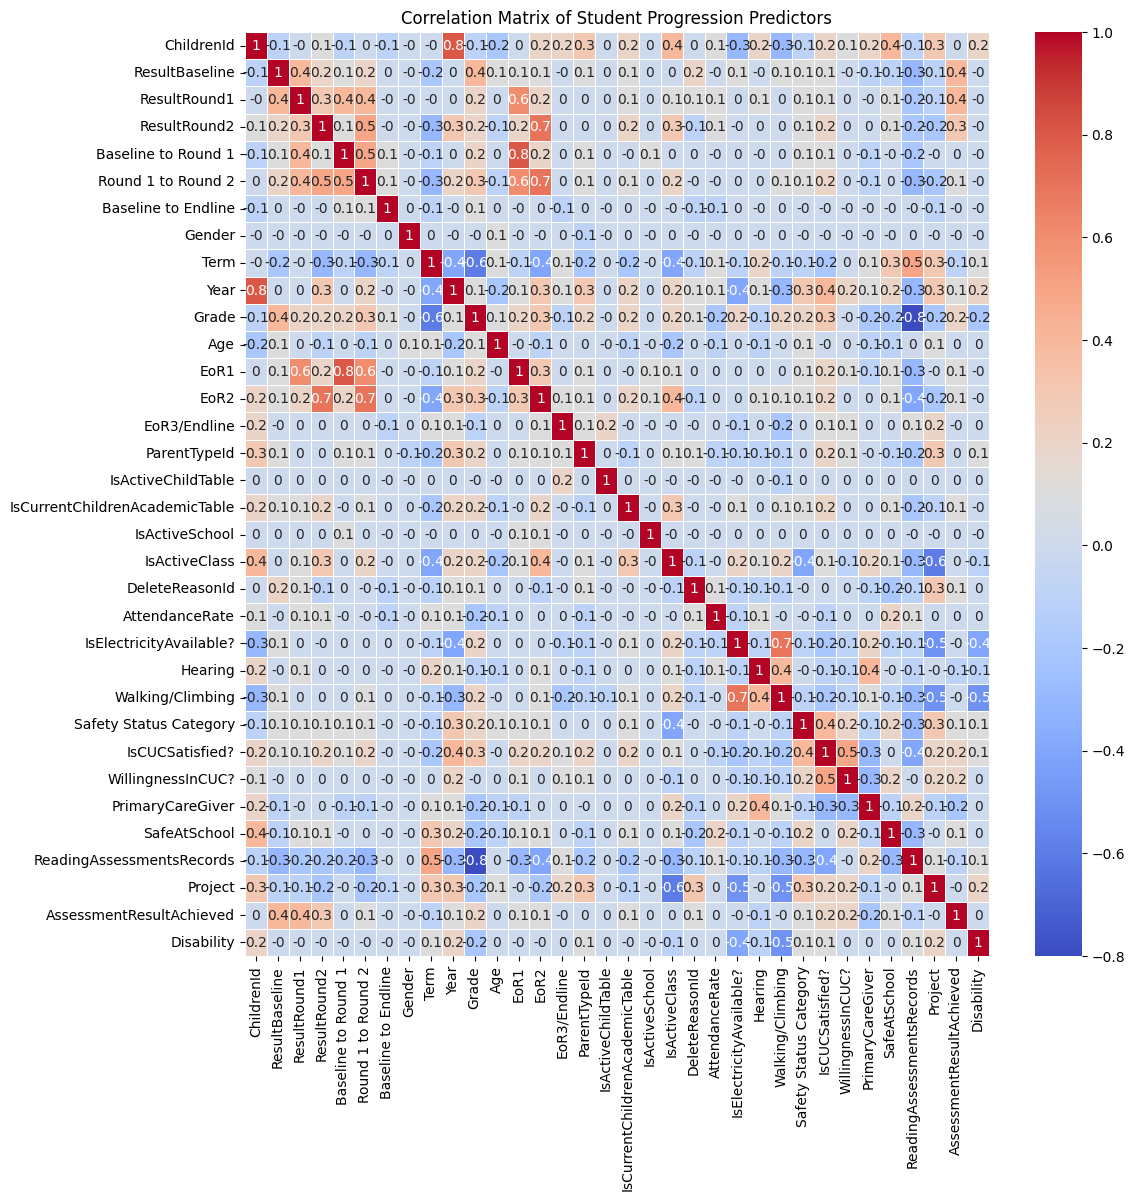

In [58]:
# drop highly inner correlated columns:
cols_drop = ['AcademicYearId', 
                'Baseline_Endline', 'ResultEndline',
                'StoryAchieved', 'ComprehensionAchieved', 'Comprehension Level',
                 'AtLeastAchievedSentence',
                 'FloorMaterial', 'RoofMaterial','WallMaterial', 'IsRadioTVAvailable?',
                 'IsTelephoneAvailable?', 'IsBikeAvailable?',  'MemoryConcentration', 'Selfcare',
                'CommunicationIssue', 'Vision', 'SafeAtHome', 'ClassID', 'LastCuCCycleStatus', 'SchoolID']

corr_matrix = merged_df2.drop(cols_drop, axis=1).corr().round(1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Student Progression Predictors')
plt.show()

# Feature importance analysis

In [57]:
# Prepare features (X) and target (y)
y = merged_df2['Baseline to Endline'].astype(int)
cols_drop.extend(['Baseline to Endline', 'ChildrenId'])
X = merged_df2.drop(cols_drop, axis=1)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shape of train and test data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (28348, 32), X_test shape: (7088, 32)
y_train shape: (28348,), y_test shape: (7088,)


In [58]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.00      0.01       340
           1       0.85      0.97      0.91      5898
           2       0.36      0.16      0.22       850

    accuracy                           0.83      7088
   macro avg       0.47      0.38      0.38      7088
weighted avg       0.76      0.83      0.78      7088



/Users/assylnur/Desktop/BU/Fall2024/DS701_tools4ds/Spark/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


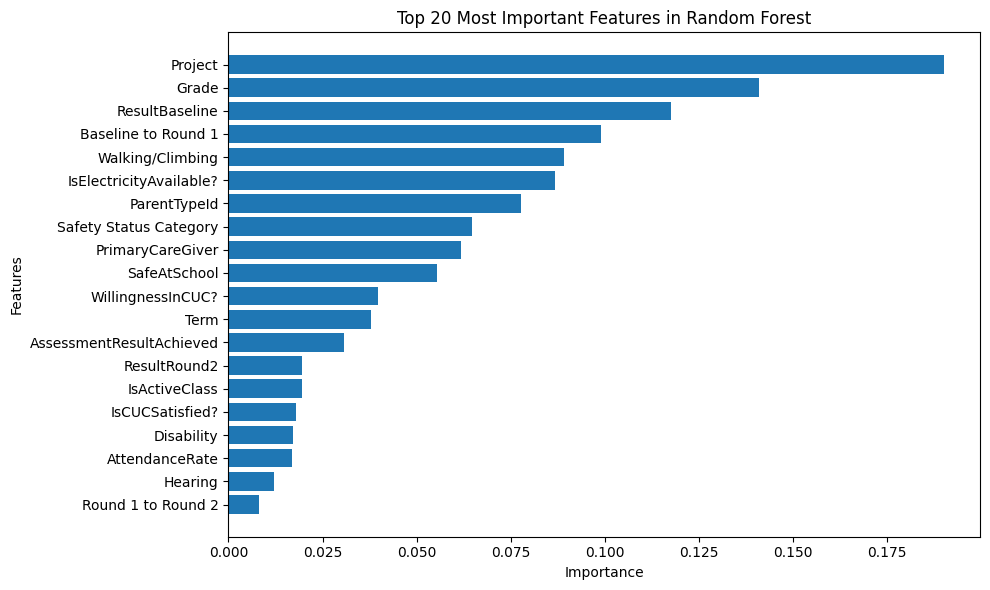

In [59]:
# Extract feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute value of the coefficients to see importance
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
N = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(N), feature_importance['Importance'].head(N),)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {N} Most Important Features in Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [60]:
print(feature_importance)

                           Feature  Coefficient  Importance
29                         Project    -0.190112    0.190112
8                            Grade     0.140791    0.140791
0                   ResultBaseline     0.117635    0.117635
3              Baseline to Round 1    -0.099058    0.099058
22                Walking/Climbing     0.089104    0.089104
20         IsElectricityAvailable?     0.086858    0.086858
13                    ParentTypeId    -0.077767    0.077767
23          Safety Status Category    -0.064715    0.064715
26                PrimaryCareGiver    -0.061743    0.061743
27                    SafeAtSchool    -0.055520    0.055520
25               WillingnessInCUC?    -0.039807    0.039807
6                             Term    -0.037961    0.037961
30        AssessmentResultAchieved    -0.030668    0.030668
2                     ResultRound2     0.019629    0.019629
17                   IsActiveClass     0.019618    0.019618
24                 IsCUCSatisfied?     0

In [61]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       340
           1       0.96      0.99      0.97      5898
           2       0.86      0.76      0.80       850

    accuracy                           0.95      7088
   macro avg       0.90      0.83      0.86      7088
weighted avg       0.94      0.95      0.94      7088



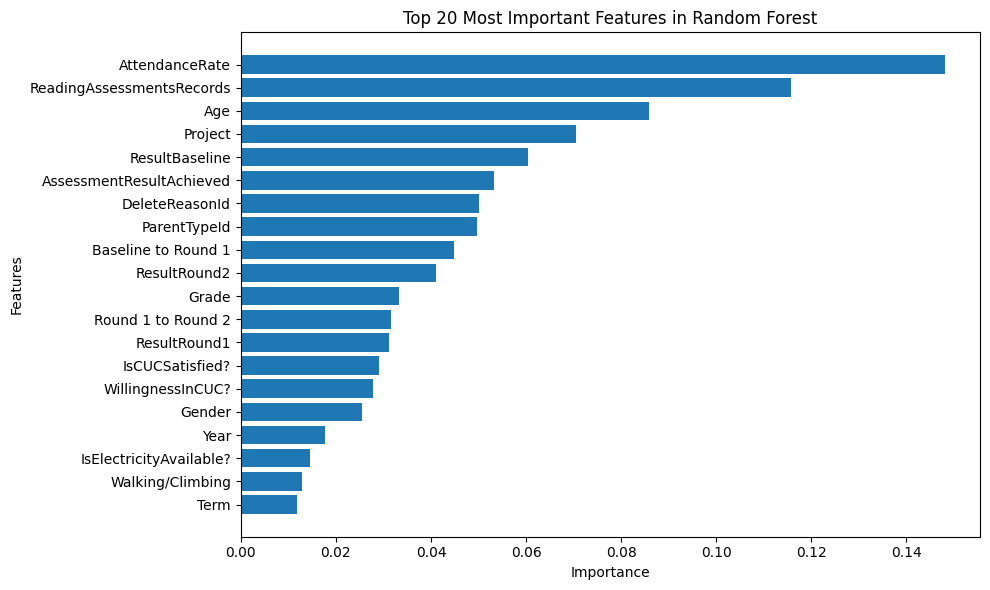

In [62]:
# Get feature importance from the trained model
feature_importance = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


# Plot the top 20 features
N = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(N), feature_importance_df['Importance'].head(N),)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {N} Most Important Features in Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


In [63]:
feature_importance_df

,Feature,Importance
19,AttendanceRate,0.148072
28,ReadingAssessmentsRecords,0.115647
9,Age,0.085959
29,Project,0.070547
0,ResultBaseline,0.060383
30,AssessmentResultAchieved,0.053297
18,DeleteReasonId,0.050181
13,ParentTypeId,0.049786
3,Baseline to Round 1,0.044754
2,ResultRound2,0.041034


In [64]:
feature_importance_df.to_excel('data/Uganda_FE.xlsx')